In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from grouplasso import GroupLassoRegressor
from sklearn.preprocessing import StandardScaler

In [185]:
class Ista:
    def __init__(self, alpha=0.1, maxiter=100, tol=1e-4):
        self.alpha = alpha
        self.maxiter = maxiter
        self.tol = tol
        self.coef = []
    
    def fit(self, X, y):
        self.coef_ = np.zeros(X.shape[1])
        rho = self._supermum_eigen(X.T @ X)
        for it in range(self.maxiter):
            self.coef_ = self._update(self.coef_, X, y, rho)
            
    def predict(self, X):
        return X @ self.coef_
    
    def _update(self, x0, X, y, rho):
        res = y - X @ x0
        return self._soft_threshold(x0 + (X.T @ res) / rho, self.alpha / rho)
    
    def _soft_threshold(self, y, alpha):
        return np.sign(y) * np.maximum(np.abs(y) - alpha, 0.0)
        
    def _supermum_eigen(self, X):
        return np.max(np.sum(np.abs(X), axis=0))

In [186]:
from sklearn.base import BaseEstimator, RegressorMixin
class Admm(BaseEstimator, RegressorMixin):
    def __init__(self, lambd=1.0, rho=1.0, max_iter=1000):
        self.lambd = lambd
        self.rho = rho
        self.threshold = lambd / rho
        self.max_iter = max_iter
        self.coef_ = None
        self.intercept_ = 0.0

    def _soft_threshold(self, x):
        t = self.threshold

        positive_indexes = x >= t
        negative_indexes = x <= t
        zero_indexes = abs(x) <= t

        y = np.zeros(x.shape)
        y[positive_indexes] = x[positive_indexes] - t
        y[negative_indexes] = x[negative_indexes] + t
        y[zero_indexes] = 0.0

        return y

    def fit(self, A, b):
        N = A.shape[0]
        M = A.shape[1]
        inv_matrix = np.linalg.inv(np.dot(A.T, A) / N + self.rho * np.identity(M))

        x = np.dot(A.T, b) / N
        z = x.copy()
        y = np.zeros(len(x))

        for iteration in range(self.max_iter):
            x = np.dot(inv_matrix, np.dot(A.T, b) / N + self.rho * z - y)
            z = self._soft_threshold(x + y / self.rho)
            y += self.rho * (x - z)

        self.coef_ = x

        return self

    def predict(self, X):
        return X @ self.coef_

In [187]:
data = pd.read_csv("../data/data.csv")

In [188]:
data.head()

,Unnamed: 0,y,x1,x2,x3,x4,x5
0,1,-12.101067,6,16.187861,16.466228,21.955828,9
1,2,-5.504248,6,24.156027,23.589765,30.090739,11
2,3,-0.726944,5,22.491387,22.917049,27.191039,12
3,4,6.830745,5,20.606433,21.622642,26.420948,3
4,5,-2.382588,5,15.933283,16.521607,21.898124,13


In [189]:
X = data[['x1', 'x2', 'x3', 'x4', 'x5', 'y']].values
X = StandardScaler().fit_transform(X)
y = X[:, 5]
X = X[:, :5]

In [190]:
X.shape

(1000, 5)

In [191]:
y.shape

(1000,)

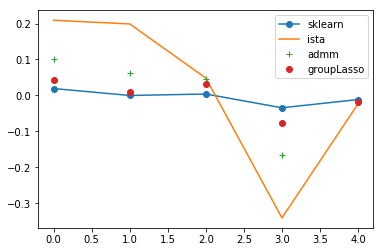

In [192]:
alpha = 0.01
lasso = Lasso(alpha=alpha, fit_intercept=False, tol=1e-5)
lasso.fit(X, y)

ista = Ista(alpha, 30000, 1e-5)
ista.fit(X, y)

admm = Admm(lambd=0.005, rho=1, max_iter=30000)
admm.fit(X, y)


group_ids = np.array([0, 0, 1, 1, 1])
eta = 0.2    # 学習率
group_lasso = GroupLassoRegressor(group_ids=group_ids, random_state=42, alpha=alpha, verbose=False, eta=eta)
group_lasso.fit(X, y)

# compare
plt.plot(lasso.coef_, '-o', label='sklearn')
plt.plot(ista.coef_, '-', label='ista')
plt.plot(admm.coef_, '+', label='admm')
plt.plot(group_lasso.coef_, 'o', label='groupLasso')
plt.legend()

In [193]:
admm.coef_

array([ 0.10150515,  0.06295129,  0.04483574, -0.16539947, -0.01714344])

In [194]:
group_lasso.coef_

array([ 0.04425793,  0.01054621,  0.03105695, -0.07694758, -0.0192625 ])